# Cartpole - Hill Climbing

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

print('Observation Space ', env.observation_space)
print('Action Space ', env.action_space)

Observation Space  Box(4,)
Action Space  Discrete(2)


## Policy

In [3]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4 * np.random.rand(s_size, a_size)
    
    def forward(self, state):
        x = np.dot(state, self.w)
        x = np.exp(x) / sum(np.exp(x))
        return x
    
    def act(self, state):
        probs = self.forward(state)
        action = np.argmax(probs) # Deterministic Policy
        # action = np.random.choice(2, p=probs) # Stochastic Policy
        return action

## Training Agent

In [4]:
policy = Policy()

def hill_climbing(eps=1000, max_t=1000, gamma=1.0, pe=100, noise_scale=1e-2): # standard deviation of additive noise

    scores_deque = deque(maxlen=100)
    scores = []

    best_R = -np.Inf
    best_w = policy.w
    
    for i in range(1, eps+1):
        rewards = []
        state = env.reset()
        
        for t in range(max_t):
            action = policy.act(state)
            
            state, reward, done, info = env.step(action)
            
            rewards.append(reward)
            
            if done:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = [a*b for a,b in zip(discounts, rewards)]
        R = sum(R)
        
        if R >= best_R:
            best_R = R
            best_w = policy.w
            
            noise_scale = max(1e-3, noise_scale/2)
            policy.w = policy.w + noise_scale * np.random.rand(*policy.w.shape)
            
        else:
            noise_scale = min(2, noise_scale*2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)
            
    
        if i % pe == 0:
            print('Episode {} Avg Score {:.2f}'.format(i, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 195.0:
            print('[Solved] {:d} Episodes Avg Score {:.2f}'.format(i-100, np.mean(scores_deque)))

            policy.w = best_w
            break
            
    return scores

scores = hill_climbing()

Episode 100 Avg Score 175.07
[Solved] 13 Episodes Avg Score 196.49


## Scores

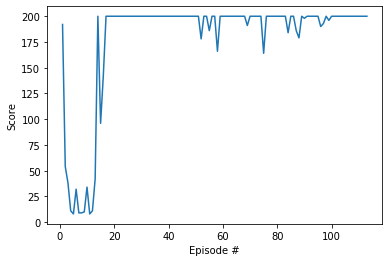

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.arange(1, len(scores)+1)
y = scores

plt.plot(x, y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Agent

In [6]:
from gym import wrappers

env_to_wrap = gym.make('CartPole-v0')

env = wrappers.Monitor(env_to_wrap, 'vid', force=True)

state = env.reset()

for t in range(200):
    action = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)

    if done:
        break 

env.close()